## Assignment 3

#### Import Required libraries

In [4]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
import chess
import chess.pgn
import io
import re
import time
# import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

#### Import csv file

In [5]:
# todo: i forgor what the exact file is called, update this
CHESS_DATA_LOCATION = "data/club_games_data.csv"
# MOVIES_DATA_LOCATION = "data/movies.csv"

# load csv into a big dataframe
chess_data = pd.read_csv(CHESS_DATA_LOCATION)
print(len(chess_data))

66879


In [6]:
print(chess_data.dtypes)
# print(chess["rules"].unique())
# ['chess' 'chess960' 'threecheck' 'crazyhouse' 'kingofthehill']
# dunno if we should filter by chess only

# time control
#['1/259200' '1/172800' '1800' '1/86400' '1/432000' '1/604800' '600'
#  '120+1' '900+10' '300' '180+2' '3600+5' '2700+45' '3600' '1/1209600'
#  '180' '600+10' '60' '480+3' '300+5' '420+3' '600+5' '600+2' '1200' '30'
#  '60+1' '120' '1500+3' '900+2' '1500+5' '1500+10' '1/864000' '900' '300+2'
#  '1500' '7200' '300+1' '5400' '3600+60' '2700+30' '3480+45' '10' '2700+10'
#  '15' '2700' '3600+20' '4500' '4200' '900+5' '1800+10' '2700+5' '480+5'
#  '1800+30' '300+3' '600+1' '1800+5' '420+5' '5400+30' '240+10' '420' '303'
#  '60+10']
# so many types of time control -_-

# time class
# ['daily' 'rapid' 'bullet' 'blitz']

white_username    object
black_username    object
white_id          object
black_id          object
white_rating       int64
black_rating       int64
white_result      object
black_result      object
time_class        object
time_control      object
rules             object
rated               bool
fen               object
pgn               object
dtype: object


#### Clean data
Filter out NaN
Lila come back here, can't think of anything else for now

In [7]:
# Drops rows if any value is a NaN, but data is clean so it doesn't do anything
chess_data.dropna(axis = 0, how = 'any')
# filter out alternative rules like chess960 etc
chess_data = chess_data[chess_data['rules'] == "chess"]
# remove any game that starts with rnbqkbnr cos that shows the game barely developed

# 1360 entries
chess_data = chess_data[~(chess_data['white_result'] == chess_data['black_result'])]

# if the game ends with "rnbqkbnr", that indicates a very undeveloped board,
# i.e. the game barely started so it shouldn't be counted
chess_data = chess_data[~chess_data['fen'].str.startswith("rnbqkbnr/")] # 1360 entries
counter = 0

# get id's of values to drop (so the for loop doesn't mess up )
drops = []
# preemptive index reset
chess_data = chess_data.reset_index(drop=True)
# for any in the chess data
for i in range(len(chess_data)):
    # get pgn string (final line of pgn column)
    pgn = chess_data['pgn'][i].splitlines()[-1]
    # find all entries of a move
    # i.e. "1." or "2."
    entries = re.findall("[123456789]\.", pgn)
    
    filter_n = 5
    # for the second type of pgn, detect timestamps and
    # since moves are labelled 1. 1... 2. 2..., double the filter size
    if (re.search("\{\[.{12,13}\]\}",pgn) != None):
        # i.e. "1. g4 {[%clk 47:56:02]}"
        filter_n = 10

    # if there's less than 5 moves, then delete entry
    if (len(entries) < filter_n):
        # print(pgn)
        drops.append(chess_data.index[i])
        # chess_data = chess_data.drop(chess_data.index[i])
        # chess_data = chess_data.reset_index(drop=True)

# drop every entry with a drop ID
for drop_id in drops:
    chess_data = chess_data.drop(drop_id)
chess_data = chess_data.reset_index(drop=True)

print(len(chess_data))

1. d4 c6 2. c4 d5 3. Bf4 Bf5 4. Nc3 e6 0-1
1. d4 Nf6 2. c4 g6 0-1
1. e4 c5 2. Nf3 Nc6 3. d4 cxd4 4. Nxd4 1-0
1. e4 c5 2. Bc4 e6 3. Nc3 Nc6 4. d3 1-0
1. d4 d5 2. c4 e6 3. e3 Nf6 4. a3 c5 0-1
0-1
1. e4 b6 2. Bc4 e6 3. d3 Bb7 0-1
1. e4 {[%clk 22:49:46]} 1... e5 {[%clk 23:56:29]} 2. Nf3 {[%clk 23:55:40]} 2... Nc6 {[%clk 23:55:49]} 1-0
1. g4 {[%clk 0:00:48.4]} 1... Nf6 {[%clk 0:00:57.9]} 0-1
0-1
3. Nc3 {[%clk 64:51:01]} 1-0
6. Bg5 {[%clk 71:17:05]} 1-0
1. c4 {[%clk 68:59:29]} 1... e5 {[%clk 57:52:09]} 2. d3 {[%clk 61:43:43]} 2... Nf6 {[%clk 34:47:34]} 0-1
3... Qh4+ 4. g3 fxg3 5. Nf3 Qxh2 0-1
1. e4 Nf6 2. d3 e5 0-1
1. d4 d5 2. e3 Nf6 3. Ke2 Bg4+ 0-1
1. e4 e5 2. Nf3 Nf6 3. Nc3 Nxe4 4. Nxe4 1-0
1. d4 {[%clk 41:08:25]} 1... Nc6 {[%clk 57:38:40]} 2. Bf4 {[%clk 64:16:33]} 1-0
1. d4 {[%clk 47:25:30]} 1... Nf6 {[%clk 21:36:10]} 2. Bf4 {[%clk 39:54:03]} 1-0
1. e4 {[%clk 312:45:52]} 1... e5 {[%clk 335:56:18]} 2. Bb5 {[%clk 335:59:41]} 2... Nf6 {[%clk 335:54:13]} 0-1
1. Bf4 {[%clk 0:02:46.7]} 1-0
2. e

In [8]:
print(len(chess_data[chess_data["time_class"] == "daily"]))
print(len(chess_data[chess_data["time_class"] == "rapid"]))
print(len(chess_data[chess_data["time_class"] == "bullet"]))
print(len(chess_data[chess_data["time_class"] == "blitz"]))

chess_data_sample = chess_data.groupby('time_class', group_keys=False).apply(lambda x: x.sample(frac=0.2))

1240
12035
21554
27211


#### Get pgn from last column - can we import things for this?
Idk if it works yet cos am not actually using the file
Lila come back to this

Lila see if can do by getting to '] {new line} 1. ' in one swoop, instead of finding '[Link ' then '1. '

In [9]:
# Save pgn column from dataframe
full_pgn = chess_data['pgn']

def get_moves(entry):
    '''
    Retrive series of moves in a game when given the whole full_pgn entry
    '''
    # # Find last occurrence of ']' in each full_pgn entry
    # link_bracket = entry.rindex('[Link ')

    # # Cut non-move info of full_pgn
    # pgn = full_pgn[link_bracket ::]

    # # Find first occurrence of '1. ', signifying first move, in each full_pgn entry
    # first_move_index = pgn.rindex('1. ')


    # pgn is just a string "separated" by newlines so turn into an array, and pgn is
    # always the final entry in the array. though turning into array may not be the most
    # efficient maybe? not sure tho  - leon
    pgn = entry.splitlines()[-1]
    return pgn

chess_data['move_list'] = full_pgn.apply(get_moves)
print(chess_data['move_list'][134])
# get_moves(full_pgn[0])
# ouput: '1. d4 Nf6 2. c4 e6 3. Nc3 Bb4 4. Qb3 Bxc3+ 5. Qxc3 O-O 6. Bg5 c5 7. dxc5 Nc6 8. Nf3 Qa5 9. Bxf6 gxf6 10. Qxa5 Nxa5 11. e3 Rd8 12. Rd1 Kg7 13. Be2 b6 14. Rd4 bxc5 15. Rg4+ Kh6 16. Bd3 f5 17. Rh4+ Kg6 18. g4 Ba6 19. gxf5+ exf5 20. Ne5+ Kf6 21. Rh6+ Kxe5 22. f4# 1-0'

1. e4 {[%clk 0:10:00]} 1... c5 {[%clk 0:09:58.8]} 2. Nf3 {[%clk 0:09:59.9]} 2... Nc6 {[%clk 0:09:56.8]} 3. d4 {[%clk 0:09:59.3]} 3... cxd4 {[%clk 0:09:55.9]} 4. Nxd4 {[%clk 0:09:59.2]} 4... d6 {[%clk 0:09:54.9]} 5. Nc3 {[%clk 0:09:57.3]} 5... e5 {[%clk 0:09:53.7]} 6. Nf3 {[%clk 0:09:54.8]} 6... Nf6 {[%clk 0:09:46.7]} 7. Bc4 {[%clk 0:09:54.3]} 7... a6 {[%clk 0:09:44.2]} 8. O-O {[%clk 0:09:53.5]} 8... Bd7 {[%clk 0:09:41.1]} 9. Bg5 {[%clk 0:09:43.2]} 9... Be7 {[%clk 0:09:39.4]} 10. Qd2 {[%clk 0:09:34.4]} 10... h6 {[%clk 0:09:35.2]} 11. Bxf6 {[%clk 0:09:30.3]} 11... Bxf6 {[%clk 0:09:33]} 12. Rad1 {[%clk 0:09:29.6]} 12... Be7 {[%clk 0:09:28.4]} 13. Nd5 {[%clk 0:09:28.9]} 13... O-O {[%clk 0:09:26.2]} 14. Nxe7+ {[%clk 0:09:27.3]} 14... Qxe7 {[%clk 0:09:25]} 15. Qxd6 {[%clk 0:09:27]} 15... Rad8 {[%clk 0:09:12.2]} 16. Qxe7 {[%clk 0:09:17.6]} 16... Nxe7 {[%clk 0:09:10.8]} 17. Nxe5 {[%clk 0:09:17.1]} 17... Bc8 {[%clk 0:08:53]} 18. Rxd8 {[%clk 0:09:13]} 18... Rxd8 {[%clk 0:08:51.5]} 19. Bxf7+ {[%c

#### Import chess info
https://python-chess.readthedocs.io/en/latest/core.html#chess.Board.san


#### En Passant functions
- has_legal_en_passant() tests if en passant capturing would actually be possible on the next move.
- has_pseudo_legal_en_passant()
- has_legal_en_passant()
- is_en_passant(move: Move) Checks if the given pseudo-legal move is an en passant capture.




Use StringIO to parse games from a string. Lila Use this to apply the en passant functions to for each game???

```python
import io
pgn = io.StringIO("1. e4 e5 2. Nf3 *")
game = chess.pgn.read_game(pgn)
```

### Number of games with at least 1 possible en-passant move:
## 4750
(maybe 4913 or even 4945)

### Number of games with an actual en-passant move:
## 1566

In [10]:
# chess_data

# empty wins and ELO difference array
wins = []
wins_split = [[] for _ in range(6)]
# diffs split
# 0 to 500 | 500 to 1k | 1k to 1.5k | 1.5k to 2k | 2k to 2.5k | 2.5k+
diffs = []
diffs_split = [[] for _ in range(6)]

min_split = [10000] * 6
max_split = [0] * 6

ranges = [500, 1000, 1500, 2000, 2500, 3000]

for i in range(len(chess_data)):
    # get the ratings of each and the results
    white = chess_data["white_rating"][i]
    black = chess_data["black_rating"][i]
    result = chess_data["white_result"][i]

    # find ELO mismatch size
    diff = white - black
    avg = (white + black) // 2
    # if white wins then append 1
    binary_result = 0
    if (result == "win"):    
        binary_result = 1
    wins.append(binary_result)
    # append the elo mismatch
    diffs.append(diff)
    
    for j in range(6):
        if avg <= ranges[j]:
            diffs_split[j].append(diff)
            wins_split[j].append(binary_result)
            if diff <= min_split[j]:
                min_split[j] = diff
            if diff >= max_split[j]:
                max_split[j] = diff

# set to numpy array to be able to do logistic regression
np_diffs = np.array(diffs).reshape(-1,1)
np_wins = np.array(wins)

# fit logistic regression
total_model = LogisticRegression().fit(np_diffs, np_wins)

split_model = []

# print(wins_split[0])

for i in range(6):
    np_diffs_split = np.array(diffs_split[i]).reshape(-1,1)
    np_wins_split = np.array(wins_split[i])
    split_model.append(LogisticRegression().fit(np_diffs_split, np_wins_split))

beta0 = total_model.intercept_[0]
beta1 = total_model.coef_[0][0]
print("Beta 0: " + str(beta0) + ", Beta 1: " + str(beta1))

Beta 0: 0.07632738245653549, Beta 1: 0.01025283457088308


Text(0, 0.5, 'Win probability')

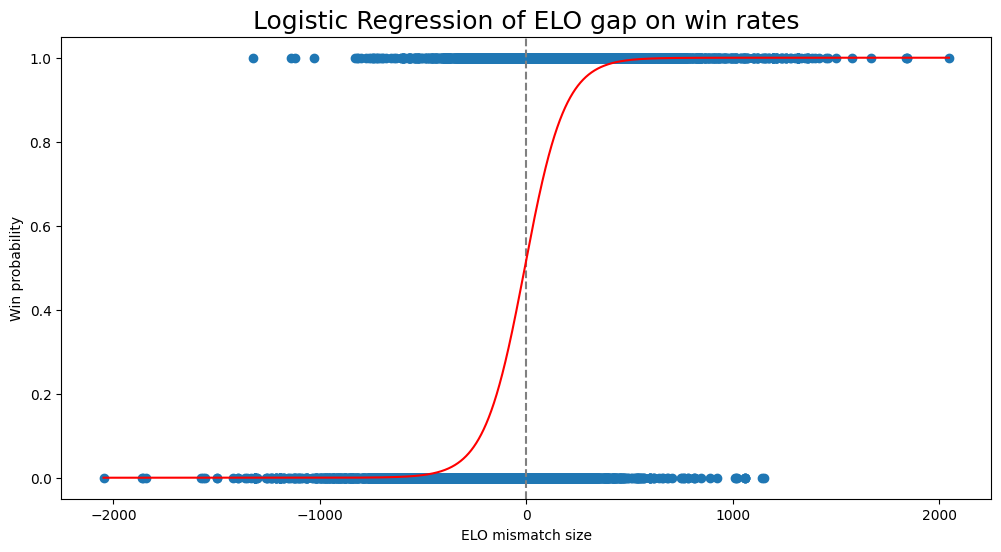

In [11]:
fig, ax1 = plt.subplots(figsize=(12,6))
# binary scatter plot
ax1.scatter(diffs, wins)

# np.arange for the range of values in the difference of ELO
x = np.arange(np_diffs.min(), np_diffs.max(), 0.1)
ax1.axvline(x = 0, color="gray", linestyle="dashed")

# plot logistic regression estimator
ax1.plot(x, total_model.predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")
ax1.set_title("Logistic Regression of ELO gap on win rates", fontsize=18)
ax1.set_xlabel("ELO mismatch size")
ax1.set_ylabel("Win probability")

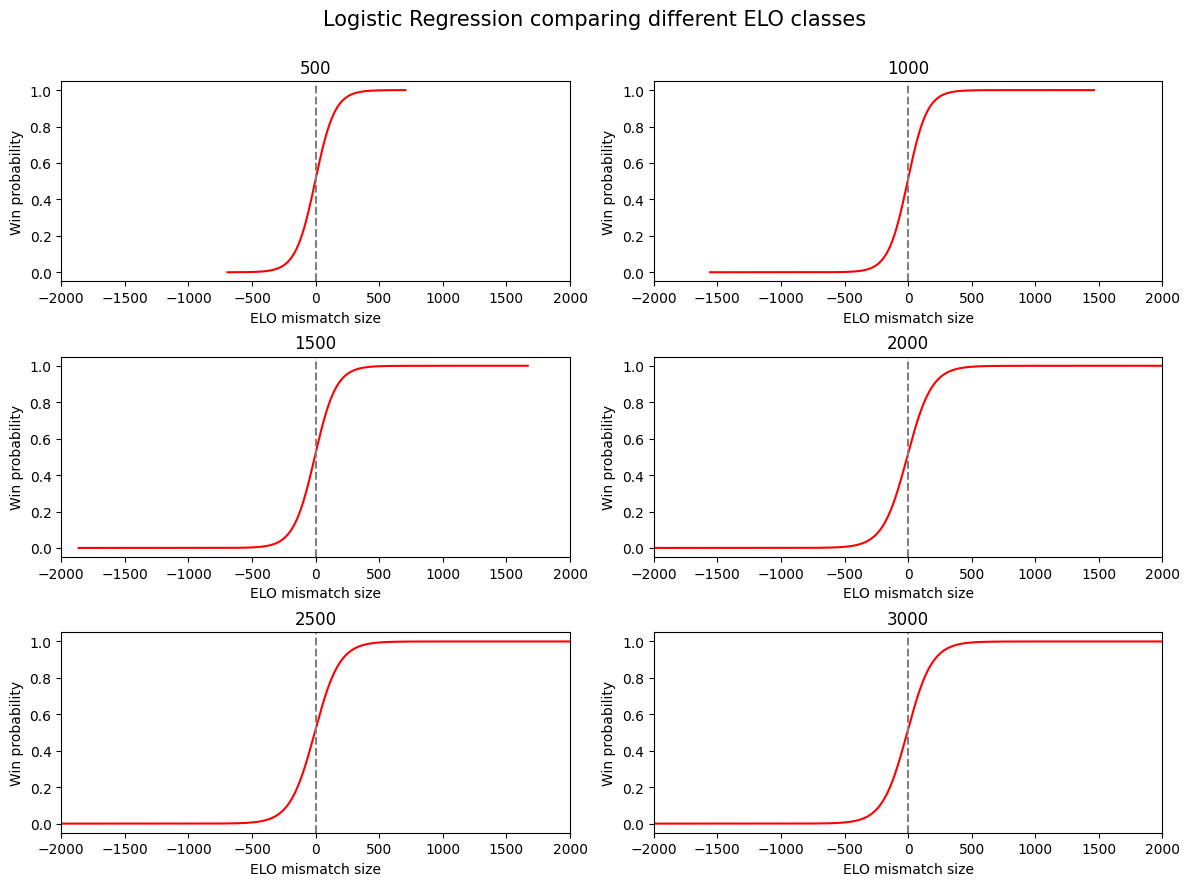

In [12]:
fig, ax2 = plt.subplots(3,2,figsize=(12,9))
# binary scatter plot

# np.arange for the range of values in the difference of ELO

# plot logistic regresion estimator

for i in range(6):
    x = np.arange(min_split[i], max_split[i], 0.1)
    ax2[i//2][i%2].plot(x, split_model[i].predict_proba(np.reshape(x, (-1, 1)))[:,1], color="red")
    
    ax2[i//2][i%2].axvline(x = 0, color="gray", linestyle="dashed")
    ax2[i//2][i%2].set_xlabel("ELO mismatch size")
    ax2[i//2][i%2].set_ylabel("Win probability")
    ax2[i//2][i%2].set_xlim([-2000, 2000])
    ax2[i//2][i%2].set_title(str(ranges[i]))

fig.tight_layout()
fig.suptitle("Logistic Regression comparing different ELO classes", fontsize=15)
fig.subplots_adjust(top=0.9)